# Same day FOVs, TCs, traces
Make plots of the FOVs, dFF traces, kinematics, and tuning curves for two experiments on the same day in the same animal

In [6]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
import numpy as np
import os
import sys
import h5py
import cv2
import importlib
import holoviews as hv
hv.extension('bokeh')

import pandas as pd
import matplotlib.pyplot as plt
from skimage import color
from hmmlearn import hmm

sys.path.insert(0, os.path.abspath(r'C:/Users/mmccann/repos/bonhoeffer/prey_capture/'))
import paths
import processing_parameters
import functions_bondjango as bd
import functions_misc as fmisc
import functions_matching as fm
import functions_data_handling as fdh
import functions_tuning as tuning
import functions_plotting as fp
import functions_kinematic as fk
from wirefree_experiment import WirefreeExperiment, DataContainer
from functions_wirefree_trigger_fix import get_trial_duration_stats

# fig_path = paths.wf_figures_path
fig_path = r"H:\thesis\figures"

# Load Data

In [7]:
def drop_partial_or_long_trials(df, min_trial_length=4.5, max_trial_length=5.5):
    """
    This function drops trials that are shorter than min_trial_length (partial trials) and
    trials that are longer than max_trial_length (errors in trial number indexing) from the dataframe.

    Parameters:
    df (DataFrame): The dataframe containing the trials.
    min_trial_length (float): The minimum length for a trial. Defaults to 4.5.
    max_trial_length (float): The maximum length for a trial. Defaults to 5.5.

    Returns:
    DataFrame: The dataframe after dropping the partial and long trials.
    """

    trial_lengths = df[df.trial_num > 0].groupby('trial_num').apply(lambda x: x.shape[0] / processing_parameters.wf_frame_rate)

    # Drop trials that are shorter than min_trial_length (partial trials)
    short_trials = trial_lengths[trial_lengths < min_trial_length].index
    df = df.drop(df[df.trial_num.isin(short_trials)].index)

    # Drop trials that are longer than max_trial_length (errors in trial number indexing)
    long_trials = trial_lengths[trial_lengths > max_trial_length].index
    df = df.drop(df[df.trial_num.isin(long_trials)].index).reset_index(drop=True)

    return df


def filter_viewed_trials(kinematics, activity_df):

    # Filter trials by head pitch if freely moving
    pitch_lower_cutoff = processing_parameters.head_pitch_cutoff[0]
    pitch_upper_cutoff = processing_parameters.head_pitch_cutoff[1]
    view_fraction = processing_parameters.view_fraction
    kinematics['viewed'] = np.logical_and(kinematics['head_pitch'].to_numpy() >= pitch_lower_cutoff,
                                          kinematics['head_pitch'].to_numpy() <= pitch_upper_cutoff)
    viewed_trials = kinematics.groupby('trial_num').filter(
        lambda x: (x['viewed'].sum() / len(x['viewed'])) > view_fraction).trial_num.unique()

    viewed_activity_df = activity_df.loc[activity_df.trial_num.isin(viewed_trials)].copy()
    return viewed_activity_df


In [78]:
importlib.reload(processing_parameters)

# get the search string
search_string = 'mouse:MM_230705_b, slug:08_03_2023'     # for thesis: 'mouse:MM_221109_a, slug:01_11_2023,'
parsed_search = fdh.parse_search_string(search_string)

# get the paths from the database

# get the raw experiment
exp_query = bd.query_database('vr_experiment', search_string)
exp_query.sort(key=lambda x: x['rig'])

# Get the preprocessing file
preproc_query = bd.query_database('analyzed_data', search_string + r', analysis_type:preprocessing')
preproc_query = [q for q in preproc_query if parsed_search['mouse'].lower() in q['slug']]
preproc_query.sort(key=lambda x: x['rig'])
preproc_paths = np.sort(np.array([el['analysis_path'] for el in preproc_query if (el['analysis_type'] == 'preprocessing') and
                        (parsed_search['mouse'].lower() in el['slug'])]))

# Get the tuning curve file
tc_query = bd.query_database('analyzed_data', search_string + r', analysis_type:tc_analysis')
tc_query = [q for q in tc_query if parsed_search['mouse'].lower() in q['slug']]
tc_query.sort(key=lambda x: x['rig'])
tc_paths = np.sort(np.array([el['analysis_path'] for el in tc_query if (el['analysis_type'] == 'tc_analysis') and
                    (parsed_search['mouse'].lower() in el['slug'])]))

# Get the cell matching file
cell_match_query = bd.query_database('analyzed_data', search_string + r', analysis_type:cellmatching')
cell_match_query = [q for q in cell_match_query if parsed_search['mouse'].lower() in q['slug']]
cell_match_query.sort(key=lambda x: x['rig'])
cell_matching_path = np.array([el['analysis_path'] for el in cell_match_query if (el['analysis_type'] == 'cellmatching') and
                                (parsed_search['mouse'].lower() in el['slug']) and ('daycellmatch' in el['slug'])])

# Get the calcium file names
calcium_paths = np.array([p.replace('preproc', 'calciumraw') for p in preproc_paths])

# Parse the rigs
rigs = np.array([os.path.basename(file).split('_')[6] for file in calcium_paths])
sort_array = np.argsort(rigs)

rigs = rigs[sort_array]
calcium_paths = calcium_paths[sort_array]
preproc_paths = preproc_paths[sort_array]
tc_paths = tc_paths[sort_array]

print(cell_matching_path)
print(calcium_paths)
print(preproc_paths)
print(tc_paths)
print(rigs)

# For thesis
parsed_search['lighting'] = 'normal'
parsed_search['result'] = 'control'

In [79]:
# Load the matching assignments and find the column that corresponds to each file
assignments =  fm.match_cells(cell_matching_path[0])
new_cols = [col.split('_')[-2] for col in assignments.columns]
assignments.columns = new_cols
col_sort_idx = np.argsort(assignments.columns)
assignments = assignments[assignments.columns[col_sort_idx]]

# Use number of non-NaNs in each row to filter out components that were not registered in enough sessions
assignments_filtered = assignments.dropna().astype(int).to_numpy()
unassigned = np.array(assignments[np.sum(~np.isnan(assignments), axis=1) < 2])
unassigned = [unassigned[~np.isnan(unassigned[:, 0]), 0].astype(int), unassigned[~np.isnan(unassigned[:, 1]), 1].astype(int)]
unassigned = [np.sort(np.unique(unassigned[0])), np.sort(np.unique(unassigned[1]))]

# Specify the path to the curated cell matches file
curated_cell_matches_path = os.path.join(r"C:\Users\mmccann\Desktop", 
                                f"curated_cell_matches_{parsed_search['result']}_{parsed_search['lighting']}_{parsed_search['rig']}.xlsx")

try:
    # Read all sheets into a list of dataframes
    curated_matches_dict = pd.read_excel(curated_cell_matches_path, sheet_name=None)

    # Concatenate the dataframes into a single dataframe
    curated_matches = pd.concat(curated_matches_dict.values(), ignore_index=True)

    # Get the hand-picked matches for the current experiment
    day_mouse_curated_idxs = curated_matches[(curated_matches['mouse'] == parsed_search['mouse']) & 
                                            (curated_matches['day'] == parsed_search['slug'])]['index'].values
    
    if len(day_mouse_curated_idxs) == 0:
        raise Exception("No curated matches found for the current experiment. Continuing with CaImAn matches...")
    else:
        day_mouse_curated_matches = assignments_filtered[day_mouse_curated_idxs, :]

except Exception as e:
    print(f"Could not find the file {curated_cell_matches_path}. Continuing with CaImAn matches...")
    day_mouse_curated_matches = assignments_filtered

In [80]:
# Load freely moving data
exp_free = WirefreeExperiment(exp_info=exp_query[0], preproc_info=preproc_query[0], tc_info=tc_query[0])
exp_free._load_preprocessing()
exp_free._load_tc()

exp_free.norm_deconv_fluor = tuning.normalize_responses(exp_free.deconv_fluor.copy())
exp_free.norm_deconv_fluor = drop_partial_or_long_trials(exp_free.norm_deconv_fluor.copy())
exp_free.norm_deconv_fluor_viewed = filter_viewed_trials(exp_free.kinematics, exp_free.norm_deconv_fluor.copy())
exp_free.norm_inferred_spikes = tuning.normalize_responses(exp_free.inferred_spikes.copy())
exp_free.norm_inferred_spikes = drop_partial_or_long_trials(exp_free.norm_inferred_spikes)

# load head fixed data
exp_fixed = WirefreeExperiment(exp_info=exp_query[1], preproc_info=preproc_query[1], tc_info=tc_query[1])
exp_fixed._load_preprocessing()
exp_fixed._load_tc()

exp_fixed.norm_deconv_fluor = tuning.normalize_responses(exp_fixed.deconv_fluor.copy())
exp_fixed.norm_deconv_fluor = drop_partial_or_long_trials(exp_fixed.norm_deconv_fluor.copy())
exp_fixed.norm_deconv_fluor_viewed = exp_fixed.norm_deconv_fluor.copy()
exp_fixed.norm_inferred_spikes = tuning.normalize_responses(exp_fixed.inferred_spikes.copy())
exp_fixed.norm_inferred_spikes = drop_partial_or_long_trials(exp_fixed.norm_inferred_spikes)

In [81]:
# load the used dataset from processing params
used_activity_ds = processing_parameters.activity_datasets[0]
print(used_activity_ds)

# Select cells with particular visual response properties

In [82]:
def get_vis_tuned_cells(ds, vis_stim='dir', sel_thresh=0.3, drop_na=True):
    data = ds.copy()

    if (vis_stim == 'dir'):
        # Cells cannot be both responsive to all visual stimuli and to directions
        cells = data[(data['is_dir_responsive'] == 1) & (data['fit_dsi'] >= sel_thresh)]
                    #   & (data['fit_osi'] < sel_thresh)] & (data['is_vis_responsive'] == 0)
        return cells
    
    elif (vis_stim == 'ori'):
        # Cells cannot be both responsive to all visual stimuli and to orientations
        cells = data[(data['is_ori_responsive'] == 1) & (data['fit_osi'] >= sel_thresh)]
            #   & (data['fit_dsi'] < sel_thresh)] & (data['is_vis_responsive'] == 0)
        return cells

    elif (vis_stim == 'vis'):
        cells = data[(data['is_vis_responsive'] == 1) & (data['is_gen_responsive'] == 0)]
        return cells
    
    elif (vis_stim == 'gen') :
        cells = data[data['is_gen_responsive'] == 1]
        return cells

    else:
        return Exception('Invalid vis_stim')


def filter_vis_selectivity(fixed_exp_tcs, free_exp_tcs, matches, vis_stim, sel_thresh=0.3):

    # Get the right columns
    if vis_stim == 'dir':
        sel_var = 'fit_dsi'
        resp_test = 'is_dir_responsive'
    elif vis_stim == 'ori':
        sel_var = 'fit_osi'
        resp_test = 'is_ori_responsive'
    else:
        raise ValueError('Invalid vis_stim')

    # Find matched_cells
    free_matched = free_exp_tcs.iloc[matches[:, 0], :]
    fixed_matched = fixed_exp_tcs.iloc[matches[:, 1], :]

    # Get the selectivity values from the matched cells
    free = free_matched[sel_var].abs()
    fixed = fixed_matched[sel_var].abs()
    diff = free.values - fixed.values
    sel_matched = pd.DataFrame({'fixed': fixed.values, 'free': free.values, 'diff': diff})

    # Find matches where both are responsive
    free_responsive = free_matched[resp_test].values
    fixed_responsive = fixed_matched[resp_test].values
    diff_resp = free_responsive - fixed_responsive
    both_resp_idxs = np.argwhere(diff_resp == 0).flatten()
    gained_resp_idx = np.argwhere(diff_resp == 1).flatten()
    lost_resp_idx = np.argwhere(diff_resp == -1).flatten()

    # find cells that maintained, gained, or lost selectivity
    kept_sel = sel_matched[(sel_matched['fixed'] >= sel_thresh) & (sel_matched['free'] >= sel_thresh)]
    strengthened_sel = sel_matched[(sel_matched['fixed'] >= sel_thresh) & (sel_matched['free'] >= sel_thresh) & (sel_matched['diff'] > 0.15)]
    weakened_sel = sel_matched[(sel_matched['fixed'] >= sel_thresh) & (sel_matched['free'] >= sel_thresh) & (sel_matched['diff'] < -0.15)]
    gained_sel = sel_matched[(sel_matched['fixed'] < sel_thresh) & (sel_matched['free'] >= sel_thresh)]
    lost_sel = sel_matched[(sel_matched['fixed'] >= sel_thresh) & (sel_matched['free'] < sel_thresh)]

    sel_matched['kept'] = sel_matched.index.isin(kept_sel.index)
    sel_matched['lost'] = sel_matched.index.isin(lost_sel.index)
    sel_matched['gained'] = sel_matched.index.isin(gained_sel.index)
    sel_matched['strengthened'] = sel_matched.index.isin(strengthened_sel.index)
    sel_matched['weakened'] = sel_matched.index.isin(weakened_sel.index)
    
    return sel_matched

In [83]:
free_tcs = getattr(exp_free.visual_tcs, f'{used_activity_ds}_props')
fixed_tcs = getattr(exp_fixed.visual_tcs, f'{used_activity_ds}_props')

# Cells that are generally responsive (but not specific for visual stimuli)
free_gen_resp = get_vis_tuned_cells(free_tcs, vis_stim='gen', sel_thresh=processing_parameters.selectivity_idx_cutoff)
fixed_gen_resp = get_vis_tuned_cells(fixed_tcs, vis_stim='gen', sel_thresh=processing_parameters.selectivity_idx_cutoff)

# Cells that meet visual responsivity criteria
free_vis_resp = get_vis_tuned_cells(free_tcs, vis_stim='vis', sel_thresh=processing_parameters.selectivity_idx_cutoff)
fixed_vis_resp = get_vis_tuned_cells(fixed_tcs, vis_stim='vis', sel_thresh=processing_parameters.selectivity_idx_cutoff)

# Cells that meet direction selectivity criteria
free_dir_tuned = get_vis_tuned_cells(free_tcs, vis_stim='dir', sel_thresh=processing_parameters.selectivity_idx_cutoff)
fixed_dir_tuned = get_vis_tuned_cells(fixed_tcs, vis_stim='dir', sel_thresh=processing_parameters.selectivity_idx_cutoff)

# Cells that meet orientation selectivity criteria
free_ori_tuned = get_vis_tuned_cells(free_tcs, vis_stim='ori', sel_thresh=processing_parameters.selectivity_idx_cutoff)
fixed_ori_tuned = get_vis_tuned_cells(fixed_tcs, vis_stim='ori', sel_thresh=processing_parameters.selectivity_idx_cutoff)


# Find cells that are both direction and orientation tuned, and figure out what to do with them.
intersect, comm1, comm2 = np.intersect1d(free_dir_tuned.index, free_ori_tuned.index, return_indices=True)
free_both_tuned = free_dir_tuned.iloc[comm1].copy()

# Remove cells tuned to both from each category
free_dir_tuned = free_dir_tuned.drop(free_dir_tuned.index[comm1])
free_ori_tuned = free_ori_tuned.drop(free_ori_tuned.index[comm2])

intersect, comm1, comm2 = np.intersect1d(fixed_dir_tuned.index, fixed_ori_tuned.index, return_indices=True)
fixed_both_tuned = fixed_dir_tuned.iloc[comm1].copy()
fixed_dir_tuned = fixed_dir_tuned.drop(fixed_dir_tuned.index[comm1])
fixed_ori_tuned = fixed_ori_tuned.drop(fixed_ori_tuned.index[comm2])

# Double check cells that are visually reposnsive, make sure that all are contained in the vis_resp
free_resp_cells = np.unique(np.concatenate([free_dir_tuned.index, free_ori_tuned.index, free_both_tuned.index]))
not_in_free_resp_cells = np.setdiff1d(free_vis_resp.index, free_resp_cells, assume_unique=True)
free_vis_resp = pd.concat([free_vis_resp, free_tcs.loc[not_in_free_resp_cells, :]])
free_vis_resp = free_vis_resp.reset_index().drop_duplicates(subset=['index'])

fixed_resp_cells = np.unique(np.concatenate([fixed_dir_tuned.index, fixed_ori_tuned.index, fixed_both_tuned.index]))
not_in_fixed_resp_cells = np.setdiff1d(fixed_vis_resp.index, fixed_resp_cells, assume_unique=True)
fixed_vis_resp = pd.concat([fixed_vis_resp, fixed_tcs.loc[not_in_fixed_resp_cells, :]])
fixed_vis_resp = fixed_vis_resp.reset_index().drop_duplicates(subset=['index'])


In [84]:
print(free_dir_tuned.index.to_list(), free_ori_tuned.index.to_list())
print(fixed_dir_tuned.index.to_list(), fixed_ori_tuned.index.to_list())

In [95]:
# For thesis
# final_idxs = [4, 11, 12, 21, 27, 36, 39, 19]
# free ['cell_0013', 'cell_0026', 'cell_0027', 'cell_0049', 'cell_0075', 'cell_0119', 'cell_0133', 'cell_0045']
# fixed ['cell_0014', 'cell_0036', 'cell_0039', 'cell_0054', 'cell_0092', 'cell_0128', 'cell_0141', 'cell_0061']

num_matches = min(day_mouse_curated_matches.shape[0], 8)

ori_matched = filter_vis_selectivity(fixed_tcs, free_tcs, day_mouse_curated_matches, 'ori', sel_thresh=processing_parameters.selectivity_idx_cutoff)
dir_matched = filter_vis_selectivity(fixed_tcs, free_tcs, day_mouse_curated_matches, 'dir', sel_thresh=processing_parameters.selectivity_idx_cutoff)

ori_kept = ori_matched[ori_matched['kept']].index.values
ori_gained = ori_matched[ori_matched['gained']].index.values
ori_lost = ori_matched[ori_matched['lost']].index.values
ori_strong = ori_matched[ori_matched['strengthened']].index.values
ori_weak = ori_matched[ori_matched['weakened']].index.values

dir_kept = dir_matched[dir_matched['kept']].index.values
dir_gained = dir_matched[dir_matched['gained']].index.values
dir_lost = dir_matched[dir_matched['lost']].index.values
dir_strong = dir_matched[dir_matched['strengthened']].index.values
dir_weak = dir_matched[dir_matched['weakened']].index.values

# Choose cells somewhat at random for the thesis: want 8 in total, one from each category + 2 random
chosen_idxs = []
for arr in [ori_kept, ori_lost, ori_gained, ori_strong, ori_weak, dir_kept, dir_lost, dir_gained, dir_strong, dir_weak]:
    if arr.size > 0:
        chosen_idxs.append(np.random.choice(arr, 1)[0])

# Enforce no repeats
chosen_idxs = np.unique(chosen_idxs)

# randomly choose 2 more cells from those remaining
remaining_idxs = np.setdiff1d(np.arange(len(day_mouse_curated_matches)), chosen_idxs)
random_idxs = np.random.choice(remaining_idxs, num_matches - len(chosen_idxs), replace=False)
final_idxs = np.concatenate([chosen_idxs, random_idxs]).astype(int)

# enforce no repeats
# final_idxs = np.unique(final_idxs)

# final_idxs = [4, 11, 12, 21, 27, 36, 39, 19]
final_cells = day_mouse_curated_matches[final_idxs, :]

exp_free.cells_to_match = [f'cell_{id:04d}' for id in final_cells[:, 0]]
exp_fixed.cells_to_match = [f'cell_{id:04d}' for id in final_cells[:, 1]]
print(final_idxs)
print(exp_free.cells_to_match)
print(exp_fixed.cells_to_match)

# Generate Contour Plots

In [ ]:
def get_footprint_centroids(calcium_data):
    cents = []
    for cell in calcium_data:
        new_cell = cell.copy()
        new_cell[new_cell > 0] == 1 
        M = cv2.moments(new_cell)
        
        # centroid calciulation
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        cents.append([cX, cY])
    return cents

def get_footprint_contours(calcium_data):
    contour_list = []
    contour_stats = []
    for frame in calcium_data:
        frame = frame * 255.
        frame = frame.astype(np.uint8)
        thresh = cv2.threshold(frame, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

        # # get contours and filter out small defects
        contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        # Only take the largest contour
        cntr = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(cntr)
        perimeter = cv2.arcLength(cntr, True)
        compactness = 4*np.pi*area / (perimeter + 1e-16)**2
        
        contour_list.append(cntr)
        contour_stats.append((area, perimeter, compactness))

    return contour_list, np.array(contour_stats)

def make_contour_projection(contour_list, shape, threshold=0.1):
    contour_img = np.zeros(shape)
    for i, cntr in enumerate(contour_list):
        cv2.drawContours(contour_img[i, :], [cntr], 0, 1, 1)

    contour_img = np.sum(contour_img, axis=0)
    contour_img[contour_img > threshold] = 1.0
    return contour_img

def get_binary_footprints(footprint_pic, threshold=0.1):
    bin_pic = np.zeros_like(footprint_pic)
    bin_pic[footprint_pic > threshold] = 1
    return bin_pic

def make_rgb_overlay(max_proj, footprints, contour_img, channel='r'):
    max_proj -= max_proj.min()
    max_proj /= max_proj.max()

    # Make RGB max projection
    max_proj_rgb = np.dstack((max_proj, max_proj, max_proj))

    # mak RGB footprint image
    footprint_rgb = np.zeros((*max_proj.shape, 3))

    footprints /= footprints.max()
    if channel == 'r':
        footprint_rgb[:, :, 0] = footprints
    elif channel == 'g':
        footprint_rgb[:, :, 1] = footprints
    elif channel == 'b':
        footprint_rgb[:, :, 2] = footprints
    else:
        raise ValueError('channel must be r, g, or b')
    
    # Convert RGB max proj and RGB footprints to HSV colorspace
    max_proj_hsv = color.rgb2hsv(max_proj_rgb)
    footprint_mask_hsv = color.rgb2hsv(footprint_rgb)

    # Overlay the footprint mask on the max projection
    max_proj_hsv[..., 0] = footprint_mask_hsv[..., 0]
    max_proj_hsv[..., 1] = footprint_mask_hsv[..., 1]

    # Return to RGB colorspace
    overlay = color.hsv2rgb(max_proj_hsv)
    overlay[:] += np.expand_dims(contour_img, -1).astype(float)

    return overlay

def hv_plot_FOVs(rigs, binary_footprints, contour_images, alpha=0, labels=None, overlay=True):
    binary_images = []

    for i, (rig, bin_pic) in enumerate(zip(rigs, binary_footprints)):
        # Plot all binarized ROIS with contours
        alpha_mask = np.ones_like(bin_pic) * alpha
        bin_pic = np.dstack((bin_pic, alpha_mask))
        binary_image = hv.RGB(bin_pic.astype(float), bounds=(0, 0, 320, 320)).opts(title=rig)
        
        if labels is not None:
            cents = labels[i][:, :2].copy()
            cents[:,1] = 320 - cents[:,1]
            label = labels[i][:, -1]
            label_plot = hv.Labels({('x', 'y'): cents, 'text': label}, ['x', 'y'], 'text').opts(text_color='white', xoffset=0.05, yoffset=0.05, text_font_size='8pt')
            binary_image = binary_image * label_plot

        binary_images.append(binary_image)

    if overlay:
        binary_overlay = hv.RGB(np.dstack((contour_images[1], np.zeros_like(contour_images[0]), contour_images[0])), bounds=(0, 0, 320, 320)).opts(title='Overlay')
        binary_images.append(binary_overlay)
        
    layout = hv.Layout(binary_images).cols(len(binary_images))

    return layout


In [ ]:
# load the data for the matching
calcium_list = []
max_proj_list = []
footprint_list = []
contour_list = []
size_list = []
template_list = []
footprint_pics = []
countour_pics = []
centroids_list = []
binary_footprints = []
overlay_footprints = []
overlay_binary_footprints = []


# load the calcium data
for files, channel in zip(calcium_paths, ['b', 'r']):

    with h5py.File(files, mode='r') as f:

        try:
            calcium_data = np.array(f['A'])
            max_proj = np.array(f['max_proj'])     

        except KeyError:
            continue

    # if there are no ROIs, skip
    if (type(calcium_data) == np.ndarray) and np.any(calcium_data.astype(str) == 'no_ROIs'):
        continue
        
    # clear the rois that don't pass the size or compactness criteria
    roi_stats = fmisc.get_roi_stats(calcium_data)
    contours, contour_stats = get_footprint_contours(calcium_data)

    if len(roi_stats.shape) == 1:
        roi_stats = roi_stats.reshape(1, -1)
        contour_stats = contour_stats.reshape(1, -1)

    areas = roi_stats[:, -1]
    compactness = contour_stats[:, -1]

    keep_vector = (areas > processing_parameters.roi_parameters['area_min']) & \
                  (areas < processing_parameters.roi_parameters['area_max']) & \
                  (compactness > 0.5)

    if np.all(keep_vector == False):
        continue

    calcium_data = calcium_data[keep_vector, :, :]
    contours = [contours[i] for i, keep in enumerate(keep_vector) if keep]

    centroids = get_footprint_centroids(calcium_data)
    footprint_proj = np.sum(calcium_data, axis=0)
    binary_footprint_proj = get_binary_footprints(footprint_proj)
    contour_proj = make_contour_projection(contours, calcium_data.shape, threshold=0.5)
    
    # format and masks and store for matching
    calcium_list.append(calcium_data)
    footprint_list.append(np.moveaxis(calcium_data, 0, -1).reshape((-1, calcium_data.shape[0])))
    contour_list.append(contours)
    countour_pics.append(contour_proj)

    size_list.append(calcium_data.shape[1:])
    template_list.append(max_proj)
    max_proj_list.append((max_proj - max_proj.min())/ max_proj.max())
    footprint_pics.append(footprint_proj)
    binary_footprints.append(binary_footprint_proj)
    centroids_list.append(np.array(centroids))

    overlay_footprints.append(make_rgb_overlay(max_proj, footprint_proj, contour_proj, channel=channel))
    overlay_binary_footprints.append(make_rgb_overlay(max_proj, binary_footprint_proj, contour_proj, channel=channel))

# Filter footprints and contours based on the matching
match_ca1 = calcium_list[0][day_mouse_curated_matches[:, sort_array[0]], :]
match_ca2 = calcium_list[1][day_mouse_curated_matches[:, sort_array[1]], :]

match_footprint_projs = [np.sum(match_ca1, axis=0),  np.sum(match_ca2, axis=0)]
match_binary_footprint_projs = [get_binary_footprints(fp_proj) for fp_proj in match_footprint_projs]
match_centroids = [np.array(get_footprint_centroids(match_ca1)), np.array(get_footprint_centroids(match_ca2))]

match_contours1, _ = get_footprint_contours(match_ca1)
match_contours2, _ = get_footprint_contours(match_ca2)
match_contour_proj1 = make_contour_projection(match_contours1, match_ca1.shape)
match_contour_proj2 = make_contour_projection(match_contours2, match_ca2.shape)
match_binary_contour_projs = [match_contour_proj1, match_contour_proj2]
match_contours = [match_contours1, match_contours2]

match_overlay_binary_footprints = []
for i, channel in enumerate(['b', 'r']):
    match_overlay_binary_footprints.append(make_rgb_overlay(max_proj_list[i], match_binary_footprint_projs[i], match_binary_contour_projs[i], channel=channel))

# Filter unmatched footprints and contours based on the matching
unmatch_ca1 = calcium_list[0][unassigned[sort_array[0]], :]
unmatch_ca2 = calcium_list[1][unassigned[sort_array[1]], :]

unmatch_footprint_projs = [np.sum(unmatch_ca1, axis=0),  np.sum(unmatch_ca2, axis=0)]
unmatch_binary_footprint_projs = [get_binary_footprints(fp_proj) for fp_proj in unmatch_footprint_projs]
unmatch_centroids = [np.array(get_footprint_centroids(unmatch_ca1)), np.array(get_footprint_centroids(unmatch_ca2))]

unmatch_contours1, _ = get_footprint_contours(unmatch_ca1)
unmatch_contours2, _ = get_footprint_contours(unmatch_ca2)
unmatch_contour_proj1 = make_contour_projection(unmatch_contours1, unmatch_ca1.shape)
unmatch_contour_proj2 = make_contour_projection(unmatch_contours2, unmatch_ca2.shape)
unmatch_binary_contour_projs = [unmatch_contour_proj1, unmatch_contour_proj2]
unmatch_contours = [unmatch_contours1, unmatch_contours2]

unmatch_overlay_binary_footprints = []
for i, channel in enumerate(['b', 'r']):
    unmatch_overlay_binary_footprints.append(make_rgb_overlay(max_proj_list[i], unmatch_binary_footprint_projs[i], unmatch_binary_contour_projs[i], channel=channel))

## Plot all cells, matches, and not matched cells

In [ ]:
all_cell_labels = [np.concatenate((centroids, np.arange(centroids.shape[0]).reshape(-1,1)), axis=1) for centroids in centroids_list]
all_cells = hv_plot_FOVs(rigs, overlay_binary_footprints, countour_pics, overlay=True, labels=all_cell_labels)

matched_cell_labels = [np.concatenate((match_centroids[i], day_mouse_curated_matches[:, i].reshape(-1,1)), axis=1) for i in np.arange(len(match_centroids))]
match_cells = hv_plot_FOVs(rigs, match_overlay_binary_footprints, match_binary_contour_projs, 
                           overlay=True, labels=matched_cell_labels).opts(hv.opts.RGB(title=''))

unmatched_cell_labels = [np.concatenate((unmatch_centroids[i], unassigned[i].reshape(-1,1)), axis=1) for i in np.arange(len(unmatch_centroids))]
unmatch_cells = hv_plot_FOVs(rigs, unmatch_overlay_binary_footprints, unmatch_binary_contour_projs, 
                             overlay=True, labels=unmatched_cell_labels).opts(hv.opts.RGB(title=''))

match_plot = hv.Layout(all_cells + match_cells + unmatch_cells).cols(3).opts(hv.opts.RGB(xlabel=None, ylabel=None, xaxis=None, yaxis=None))

match_plot

## Plot randomly selected matched cells from the hand curated set

In [ ]:
random_idxs = np.random.choice(np.arange(len(day_mouse_curated_matches)), 5)

match_subset_countour_projs = []

for contours in match_contours:
    random_contours = [contours[i] for i in random_idxs]
    match_subset_countour_projs.append(make_contour_projection(random_contours, (len(random_contours), 320, 320)))

random_matched_cell_labels = [matched_cell_labels[i][random_idxs, :] for i in np.arange(len(matched_cell_labels))]
random_match_cells = hv_plot_FOVs(rigs, match_overlay_binary_footprints, match_subset_countour_projs, 
                                  overlay=True, labels=random_matched_cell_labels)
random_match_cells.opts(hv.opts.RGB(width=500, height=500, xlabel=None, ylabel=None, xaxis=None, yaxis=None))

# Figures 1, 2, 3, 6, 7, 10: FOV with labeled ROIs

In [ ]:
matched_cell_labels = [np.concatenate((match_centroids[i], day_mouse_curated_matches[:, i].reshape(-1,1)), axis=1) for i in np.arange(len(match_centroids))]

match_subset_countour_projs = []

for contours in match_contours:
    random_contours = [contours[i] for i in final_idxs]
    match_subset_countour_projs.append(make_contour_projection(random_contours, (len(random_contours), 320, 320)))

subset_matched_cell_labels = [matched_cell_labels[i][final_idxs, :] for i in np.arange(len(matched_cell_labels))]
subset_free_overlay = make_rgb_overlay(max_proj_list[0], binary_footprints[0], countour_pics[0], channel='g')
match_free_green = hv_plot_FOVs(rigs[:-1], [subset_free_overlay], match_binary_contour_projs[:-1], 
                           overlay=False, labels=subset_matched_cell_labels[:-1])
match_free_green = match_free_green.opts(hv.opts.RGB(title='',), hv.opts.Labels(text_color='red', xoffset=-0.5, yoffset=0.5, text_font_size='10pt'))
match_free_green = match_free_green.opts(hv.opts.RGB(width=500, height=500, xlabel=None, ylabel=None, xaxis=None, yaxis=None))

save_path = os.path.join(fig_path, '3_freely_moving_cells_traces_ethogram', 'FOV.png')
_ = fp.save_figure(match_free_green[0], save_path=save_path, fig_width=10, dpi=800, fontsize='poster', target='save', display_factor=0.2)

match_cells = hv_plot_FOVs(rigs, overlay_binary_footprints, match_subset_countour_projs, 
                           overlay=True, labels=subset_matched_cell_labels)
match_cells = match_cells.opts(hv.opts.RGB(title='',), hv.opts.Labels(text_color='red', xoffset=-0.5, yoffset=0.5, text_font_size='10pt'))
match_cells = match_cells.opts(hv.opts.RGB(width=500, height=500, xlabel=None, ylabel=None, xaxis=None, yaxis=None))

save_path = os.path.join(fig_path, '3_freely_moving_cells_traces_ethogram', 'FOV_match.png')
_ = fp.save_figure(match_cells[0], save_path=save_path, fig_width=5, dpi=800, fontsize='poster', target='save', display_factor=0.2)

save_path = os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram', 'FOV_match.png')
_ = fp.save_figure(match_cells[1], save_path=save_path, fig_width=5, dpi=800, fontsize='poster', target='save', display_factor=0.2)

save_path = os.path.join(fig_path, '10_matched_cells_example_tuning_shift', 'matched_contours.png')
_ = fp.save_figure(match_cells[2], save_path=save_path, fig_width=5, dpi=800, fontsize='poster', target='save', display_factor=0.2)

match_cells

# Figures 2 and 3: Ethogram + dFF traces

In [30]:
def plot_dff_spikes_trials(exp, save_dir, save=True, plot_spikes=True, plot_trials=True, plot_running=False, **kwargs):

    basename_modifier = kwargs.pop('basename_modifier', '')
    fig_width = kwargs.pop('fig_width', 7)
    dpi = kwargs.pop('dpi', 800)
    fontsize = kwargs.pop('fontsize', 'poster')
    
    dff_plots = []
    cells_to_plot = kwargs.pop('cells_to_plot', exp.cells_to_match)
    for i, cell in enumerate(cells_to_plot):
        basename = f"dff_{i}{basename_modifier}"

        # Plot the dff
        out_fig = hv.Curve(exp.norm_deconv_fluor[['time_vector', cell]]).opts(color='black', 
                                                                              height=kwargs.pop('height', 75), 
                                                                              width=kwargs.pop('width', 1000), 
                                                                              **kwargs)

        if plot_spikes:
            spikes_plot = hv.Curve(exp.norm_inferred_spikes[['time_vector', cell]]).opts(color='green', alpha=0.5)
            out_fig = hv.Overlay([spikes_plot, out_fig])
            basename += '_spikes'

        if plot_trials:
            trials_on = exp.norm_deconv_fluor['trial_num'] > 0
            time = exp.norm_deconv_fluor['time_vector']
            trials_plot = hv.Area((time, trials_on)).opts(color='gray', alpha=0.25)
            out_fig = hv.Overlay([trials_plot, out_fig]).opts(hv.opts.Area(yaxis=None, xaxis=None, xlabel=None, ylabel=None, show_legend=False))
            basename += '_trials'

        if plot_running:
            try:
                running_plot = hv.Curve(exp.norm_dff[['time_vector', 'running_speed']]).opts(color='red', alpha=0.5)
            except KeyError:
                running_plot = hv.Curve(exp.norm_dff[['time_vector', 'wheel_speed_abs']]).opts(color='red', alpha=0.5)

            out_fig = hv.Overlay([out_fig, running_plot])
            basename += '_running'

        # Final options for the figure
        out_fig = out_fig.opts(hv.opts.Curve(yaxis=None, xaxis=None, xlabel=None, ylabel=None, show_legend=False))
        
        # Save the figure
        save_path = os.path.join(save_dir, f'{basename}.png')

        if save:
            out_fig = fp.save_figure(out_fig, save_path=save_path, fig_width=fig_width, dpi=dpi, fontsize=fontsize, target='save', display_factor=0.3)
        else:
            out_fig = fp.save_figure(out_fig, save_path=save_path, fig_width=fig_width, dpi=dpi, fontsize=fontsize, target='screen', display_factor=0.3)

        dff_plots.append(out_fig)

    return dff_plots

## Head Fixed

In [ ]:
dff_fixed = plot_dff_spikes_trials(exp_fixed, os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram'), save=True,
                                   plot_spikes=False, plot_trials=False, plot_running=False, 
                                   fig_width=7, fontsize='paper')
# dff_fixed = hv.Layout(dff_fixed).cols(1)
# dff_fixed

In [ ]:
dff_fixed_zoom = plot_dff_spikes_trials(exp_fixed, os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram'), save=True,
                                       plot_spikes=False, plot_trials=True, plot_running=False,
                                       xlim=(770, 890), basename_modifier='_zoom', fig_width=6, fontsize='paper')
# dff_fixed_zoom = hv.Layout(dff_fixed_zoom).cols(1)
# dff_fixed_zoom

In [ ]:
# Holoviews Ethogram - Head Fixed
plt_list = []
trials_on = np.argwhere(np.diff(exp_fixed.norm_deconv_fluor['trial_num']) > 0).squeeze() + 1
trials_off = np.argwhere(np.diff(exp_fixed.norm_deconv_fluor['trial_num']) < 0).squeeze() + 1

trials_plot_list = []
for on, off in zip(trials_on, trials_off):
    time_on = exp_fixed.norm_deconv_fluor['time_vector'].iloc[on]
    time_off = exp_fixed.norm_deconv_fluor['time_vector'].iloc[off]
    trials_plot_list.append(hv.VSpan(time_on, time_off).opts(color='gray', alpha=0.25))
trials_plot = hv.Overlay(trials_plot_list)

for variable in processing_parameters.variable_list_fixed:
    save_path = os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram', f'{variable}.png')
    if variable == 'pupil_diameter':
        diam = np.unwrap(fk.jump_killer(exp_fixed.kinematics[variable].to_numpy(), 2), 10)
        var_plot = hv.Curve(diam).opts(color='black', height=50, width=1000, xaxis=None, xlabel=None, ylabel=None,)
    else:
        var_plot = hv.Curve(exp_fixed.kinematics[['time_vector', variable]]).opts(color='black', height=50, width=1000, xaxis=None, xlabel=None, ylabel=None,)

    var_plot = var_plot # * trials_plot
    var_plot = fp.save_figure(var_plot.opts(yaxis=None), save_path=save_path, fig_width=7, dpi=800, fontsize='paper', target='save', display_factor=0.2)
    plt_list.append(var_plot)

# ethogram = hv.Layout(plt_list).cols(1)
# ethogram

## Freely Moving

In [ ]:
dff_free = plot_dff_spikes_trials(exp_free, os.path.join(fig_path, '3_freely_moving_cells_traces_ethogram'), save=True,
                                  plot_spikes=False, plot_trials=False, plot_running=False, 
                                  fig_width=7, fontsize='paper')
# dff_free = hv.Layout(dff_free).cols(1)
# dff_free

In [ ]:
dff_free_zoom = plot_dff_spikes_trials(exp_free, os.path.join(fig_path, '3_freely_moving_cells_traces_ethogram'), save=True,
                                       plot_spikes=False, plot_trials=True, plot_running=False,
                                       xlim=(1050, 1170), basename_modifier='_zoom', fig_width=6, fontsize='paper')
# dff_free_zoom = hv.Layout(dff_free_zoom).cols(1)
# dff_free_zoom

In [ ]:
# Holoviews Ethogram - Freely Moving
plt_list = []
trials_on = np.argwhere(np.diff(exp_free.norm_deconv_fluor['trial_num']) > 0).squeeze() + 1
trials_off = np.argwhere(np.diff(exp_free.norm_deconv_fluor['trial_num']) < 0).squeeze() + 1

trials_plot_list = []
for on, off in zip(trials_on, trials_off):
    time_on = exp_free.norm_deconv_fluor['time_vector'].iloc[on]
    time_off = exp_free.norm_deconv_fluor['time_vector'].iloc[off]
    trials_plot_list.append(hv.VSpan(time_on, time_off).opts(color='gray', alpha=0.25))
trials_plot = hv.Overlay(trials_plot_list)

for variable in processing_parameters.variable_list_free:
    save_path = os.path.join(fig_path, '3_freely_moving_cells_traces_ethogram', f'{variable}.png')
    var_plot = hv.Curve(exp_free.kinematics[['time_vector', variable]]).opts(color='black', height=50, width=1000, xaxis=None, xlabel=None, ylabel=None,)
    var_plot = var_plot #* trials_plot
    var_plot = fp.save_figure(var_plot.opts(yaxis=None), save_path=save_path, fig_width=9, dpi=800, fontsize='paper', target='save', display_factor=0.2)
    plt_list.append(var_plot)

# ethogram = hv.Layout(plt_list).cols(1)
# ethogram

# Figures 6, 7, 10: Polar vis TC plots

## Head Fixed

In [ ]:
# Plot the polar tuning curves for the matched head fixed cells
fig_list = []
for i, cell in enumerate(exp_fixed.cells_to_match):
    fig = plt.figure(layout='constrained', figsize=(3/fp.constant_in2cm, 3/fp.constant_in2cm))

    this_fig_axes = fp.plot_tuning_with_stats(fixed_tcs, cell, subfig=fig, tuning_kind='direction', 
                                              plot_selectivity=False, font_size='paper', plot_trials=False)
    
    save_path = os.path.join(fig_path, '6_head_fixed_example_cells_fov_dir_selectivity', f'tc_{i}.png')
    fig.savefig(save_path, dpi=800, format='png')

# For nb display
# fig = plt.figure(layout='constrained', figsize=(len(fig_list)%2 * 3/fp.constant_in2cm, 3/fp.constant_in2cm * 2))
# gs = fig.add_gridspec(len(fig_list)//2, 2)

In [ ]:
# Plot the polar tuning curves for the matched head fixed cells
fig_list = []
for i, cell in enumerate(exp_fixed.cells_to_match):
    fig = plt.figure(layout='constrained', figsize=(2.5/fp.constant_in2cm, 2.5/fp.constant_in2cm))

    this_fig_axes = fp.plot_tuning_with_stats(fixed_tcs, cell, subfig=fig,
                                 tuning_kind='direction', plot_selectivity=False, 
                                 plot_trials=False, plot_pref_angle=False, font_size='paper',)
    
    save_path = os.path.join(fig_path, '10_matched_cells_example_tuning_shift', f'fixed_tc_{i}.png')
    fig.savefig(save_path, dpi=800, format='png')

# For nb display
# fig = plt.figure(layout='constrained', figsize=(len(fig_list)%2 * 3/fp.constant_in2cm, 3/fp.constant_in2cm * 2))
# gs = fig.add_gridspec(len(fig_list)//2, 2)

## Freely Moving

In [ ]:
fig_list = []
for i, cell in enumerate(exp_free.cells_to_match):
    fig = plt.figure(layout='constrained', figsize=(3/fp.constant_in2cm, 3/fp.constant_in2cm))

    this_fig_axes = fp.plot_tuning_with_stats(free_tcs, cell, subfig=fig,
                                 tuning_kind='direction', plot_selectivity=False, font_size='paper')
    
    save_path = os.path.join(fig_path, '7_freely_moving_example_cells_fov_dir_selectivity', f'tc_{i}.png')
    fig.savefig(save_path, dpi=800, format='png')

# For nb display
# fig = plt.figure(layout='constrained', figsize=(len(fig_list)%2 * 3/fp.constant_in2cm, 3/fp.constant_in2cm * 2))
# gs = fig.add_gridspec(len(fig_list)//2, 2)

In [ ]:
# Plot the polar tuning curves for the matched head fixed cells
fig_list = []
for i, cell in enumerate(exp_free.cells_to_match):
    fig = plt.figure(layout='constrained', figsize=(2.5/fp.constant_in2cm, 2.5/fp.constant_in2cm))

    this_fig_axes = fp.plot_tuning_with_stats(free_tcs, cell, subfig=fig,
                                 tuning_kind='direction', plot_selectivity=False, 
                                 plot_trials=False, plot_pref_angle=False, font_size='paper',)
    
    save_path = os.path.join(fig_path, '10_matched_cells_example_tuning_shift', f'free_tc_{i}.png')
    fig.savefig(save_path, dpi=800, format='png')

# For nb display
# fig = plt.figure(layout='constrained', figsize=(len(fig_list)%2 * 3/fp.constant_in2cm, 3/fp.constant_in2cm * 2))
# gs = fig.add_gridspec(len(fig_list)//2, 2)

# Figures 4, 6, and 7: Trial Average Responses to Visual Stimuli

In [ ]:
def parse_trial_frames(df, pre_trial=0, post_trial=0):
    trial_idx_frames = df[df.trial_num >= 1.0].groupby(['trial_num']).apply(
        lambda x: [x.index[0] - (pre_trial * processing_parameters.wf_frame_rate), 
                   x.index[0], x.index[-1], 
                   x.index[-1] + (post_trial * processing_parameters.wf_frame_rate) + 1]
        ).to_numpy()
    trial_idx_frames = np.vstack(trial_idx_frames)

    if trial_idx_frames[0, 0] < 0:
        trial_idx_frames[0, 0] = 0

    if trial_idx_frames[-1, -1] > df.index[-1]:
        trial_idx_frames[-1, -1] = df.index[-1]

    # Get the shifts from the zero point (important for plotting)
    max_zero_idx_shift = np.max(trial_idx_frames[:, 1] - trial_idx_frames[:, 0])
    
    traces = []
    for i, frame in enumerate(trial_idx_frames):
        df_slice = df.iloc[frame[0]:frame[-1], :].copy()
        df_slice['trial_num'] = df_slice.loc[frame[1], 'trial_num']
        df_slice['direction'] = df_slice.loc[frame[1], 'direction']
        df_slice['direction_wrapped'] = df_slice.loc[frame[1], 'direction_wrapped']
        df_slice['orientation'] = df_slice.loc[frame[1], 'orientation']
        zero_idx_shift = np.abs((frame[1] - frame[0]) - max_zero_idx_shift)
        df_slice['zero_idx_shift'] = zero_idx_shift

        traces.append(df_slice)
    
    traces = pd.concat(traces, axis=0).reset_index(drop=True)
    return traces, trial_idx_frames


def trial_average_response(ds, cells_to_match, stim_type):
    
    ds.dropna(inplace=True)
    idxs_shifts = ds.groupby(['trial_num']).apply(lambda x: np.unique(x.zero_idx_shift)[0]).reset_index()
    idxs_shifts = idxs_shifts.rename({0: 'zero_idx_shift'}, axis=1)	

    if stim_type in ['orientation', 'direction', 'direction_wrapped']:
        trials_per_stim = ds.groupby([stim_type, 'trial_num'])[cells_to_match].agg(list).reset_index()
        trials_per_stim = trials_per_stim.join(idxs_shifts.set_index('trial_num'), on='trial_num')
        trials_per_stim = trials_per_stim.groupby([stim_type]).agg(list)

        idxs_shifts = trials_per_stim['zero_idx_shift'].copy()
        trial_array = trials_per_stim.copy()

        for i, row in trials_per_stim.iterrows():
            for cell in cells_to_match:
                shifts = list(idxs_shifts.loc[row.name])
                trial_array.loc[i, cell] = fmisc.list_lists_to_array(row[cell], alignment='left')

        trial_averages = trial_array.applymap(np.nanmean, axis=0)
        trial_averages = trial_averages.drop('zero_idx_shift', axis=1)
        trial_array = trial_array.drop('zero_idx_shift', axis=1)  
        
    elif stim_type == 'vis':
        trials_per_stim = ds.groupby('trial_num')[cells_to_match].agg(list)
        trials_per_stim = trials_per_stim.join(idxs_shifts.set_index('trial_num'), on='trial_num')

        idxs_shifts = trials_per_stim['zero_idx_shift'].copy()
        trial_averages = trials_per_stim.iloc[0, :].copy()
        trial_array = trials_per_stim.iloc[0, :].copy()

        for cell in cells_to_match:
            trials_agg = fmisc.list_lists_to_array(trials_per_stim[cell].to_list(), alignment='left')
            trial_array[cell] = trials_agg
            trial_averages[cell] = np.nanmean(trials_agg, axis=0) 

        trial_averages = trial_averages.drop('zero_idx_shift')
        trial_array = trial_array.drop('zero_idx_shift')  
        
    else:
        raise Exception('Invalid stim_type')
    

    return trial_averages, trial_array


def hv_plot_vis_trial_averages(trial_averages, trials, cells, stim_type):

    plt_list = []

    for i, cell in enumerate(cells):

        cell_resps = trials[cell]
        cell_mean = trial_averages[cell]
        
        if stim_type in ['orientation', 'direction']:
            
            for k in range(cell_resps.shape[-1]):
                resps = cell_resps.iloc[k]
                mean = cell_mean.iloc[k]
                
                trials_list = [hv.Curve(resps[r, :]).opts(color='k', alpha=0.25, line_width=0.75) for r in np.arange(resps.shape[0])]
                mean_list = [hv.Curve(mean).opts(color='r', xlabel='', ylabel='')]
                
                if i == 0:
                    [mean_plot.opts(title=f"{cell_resps.index[k]:.1f}") for mean_plot in mean_list]

                plt_list.append(hv.Overlay(trials_list + mean_list))
                
        elif stim_type == 'vis':
            resps = cell_resps
            mean = cell_mean

            trials_list = [hv.Curve(resps[r, :]).opts(color='k', alpha=0.25, line_width=0.75) for r in np.arange(resps.shape[0])]
            mean_list = [hv.Curve(mean).opts(color='r', xlabel='', ylabel='')]
            plt_list.append(hv.Overlay(trials_list + mean_list))

        else:
            raise Exception('Invalid stim_type')
            
    return plt_list

In [ ]:
pre_trial_period = 2
post_trial_period = 2
fixed_dff_trials, fixed_tc_frames = parse_trial_frames(exp_fixed.norm_deconv_fluor.copy(), pre_trial=pre_trial_period, post_trial=post_trial_period)
free_dff_trials, free_tc_frames = parse_trial_frames(exp_free.norm_deconv_fluor.copy(), pre_trial=pre_trial_period, post_trial=post_trial_period)

## Fig 4: Visually Evoked Responses

### Head fixed

In [ ]:
vis_averages, vis_trials = trial_average_response(fixed_dff_trials.copy(), exp_fixed.cells_to_match, 'vis')

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.15)

norm_dff_vis = hv_plot_vis_trial_averages(vis_averages, vis_trials, exp_fixed.cells_to_match, 'vis')
norm_dff_vis = [trial_plot * vis_plot for vis_plot in norm_dff_vis]
norm_dff_vis = hv.Layout(norm_dff_vis).cols(len(exp_fixed.cells_to_match)).opts(hv.opts.Curve(width=100, height=160))

new_norm_dff_vis = []
for i, cell_vis_plot in enumerate(norm_dff_vis):
        save_path = os.path.join(fig_path, '4_visually_evoked_responses', f'cell_{i}_fixed.png')
        cell_vis_plot = cell_vis_plot * trial_plot
        cell_vis_plot = cell_vis_plot.opts(hv.opts.Curve(width=150, height=150, xlabel=None, ylabel=None, xaxis=None, yaxis=None, title=''))
        cell_vis_plot = fp.save_figure(cell_vis_plot, save_path=save_path, fig_width=3, dpi=800, fontsize='poster', target='save', display_factor=0.2)
        new_norm_dff_vis.append(cell_vis_plot)

hv.Layout(new_norm_dff_vis).cols(10).opts(hv.opts.Curve(width=150, height=150, xlabel=None, ylabel=None, xaxis=None, yaxis=None, title=''))

### Freely Moving

In [ ]:
vis_averages, vis_trials = trial_average_response(free_dff_trials.copy(), exp_free.cells_to_match, 'vis')

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.15)

norm_dff_vis = hv_plot_vis_trial_averages(vis_averages, vis_trials, exp_free.cells_to_match, 'vis')
norm_dff_vis = [trial_plot * vis_plot for vis_plot in norm_dff_vis]
norm_dff_vis = hv.Layout(norm_dff_vis).cols(len(exp_free.cells_to_match)).opts(hv.opts.Curve(width=100, height=160))

new_norm_dff_vis = []
for i, cell_vis_plot in enumerate(norm_dff_vis):
        save_path = os.path.join(fig_path, '4_visually_evoked_responses', f'cell_{i}_free.png')
        cell_vis_plot = cell_vis_plot * trial_plot
        cell_vis_plot = cell_vis_plot.opts(hv.opts.Curve(width=150, height=150, xlabel=None, ylabel=None, xaxis=None, yaxis=None, title=''))
        cell_vis_plot = fp.save_figure(cell_vis_plot, save_path=save_path, fig_width=3, dpi=800, fontsize='poster', target='save', display_factor=0.2)
        new_norm_dff_vis.append(cell_vis_plot)

hv.Layout(new_norm_dff_vis).cols(5)

## Direction Responses

### Figure 6: Head Fixed

In [ ]:
fixed_dir_averages, fixed_dir_trials = trial_average_response(fixed_dff_trials.copy(), exp_fixed.cells_to_match, 'direction_wrapped')

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.15)

norm_dff_dirs = hv_plot_vis_trial_averages(fixed_dir_averages, fixed_dir_trials, exp_fixed.cells_to_match, 'direction')

save_paths = []
for cell in np.arange(fixed_dir_averages.shape[1]):
    for dir in np.arange(fixed_dir_averages.shape[0]):
        save_paths.append(os.path.join(fig_path, '6_head_fixed_example_cells_fov_dir_selectivity', f'tc_cell_{cell}_{dir}.png'))

new_norm_dff_dirs = []
for i, norm_dff_i in enumerate(norm_dff_dirs):
        norm_dff_i = norm_dff_i * trial_plot
        norm_dff_i = norm_dff_i.opts(hv.opts.Curve(width=100, height=100, xlabel=None, ylabel=None, xaxis=None, yaxis=None, title=''))
        norm_dff_i = fp.save_figure(norm_dff_i, save_path=save_paths[i], fig_width=1, dpi=800, fontsize='paper', target='save', display_factor=0.2)
        new_norm_dff_dirs.append(norm_dff_i)

# hv.Layout(new_norm_dff_dirs).cols(12)

### Figure 7: Freely Moving

In [ ]:
free_dir_averages, free_dir_trials = trial_average_response(free_dff_trials.copy(), exp_free.cells_to_match, 'direction_wrapped',)

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.15)

norm_dff_dirs = hv_plot_vis_trial_averages(free_dir_averages, free_dir_trials, exp_free.cells_to_match, 'direction')

save_paths = []
for cell in np.arange(free_dir_averages.shape[1]):
    for dir in np.arange(free_dir_averages.shape[0]):
        save_paths.append(os.path.join(fig_path, '7_freely_moving_example_cells_fov_dir_selectivity', f'tc_cell_{cell}_{dir}.png'))

new_norm_dff_dirs = []
for i, norm_dff_i in enumerate(norm_dff_dirs):
        norm_dff_i = norm_dff_i * trial_plot
        norm_dff_i = norm_dff_i.opts(hv.opts.Curve(width=100, height=100, xlabel=None, ylabel=None, xaxis=None, yaxis=None, title=''))
        norm_dff_i = fp.save_figure(norm_dff_i, save_path=save_paths[i], fig_width=1, dpi=800, fontsize='paper', target='save', display_factor=0.2)
        new_norm_dff_dirs.append(norm_dff_i)

# hv.Layout(new_norm_dff_dirs).cols(12)

## Orientation Responses

### Head Fixed

In [ ]:
ori_averages, ori_trials = trial_average_response(fixed_dff_trials.copy(), exp_fixed.cells_to_match, 'orientation')

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.25)

norm_dff_oris = hv_plot_vis_trial_averages(ori_averages, ori_trials, exp_fixed.cells_to_match, 'orientation')
norm_dff_oris = [ori_plot * trial_plot for ori_plot in norm_dff_oris]
norm_dff_oris = hv.Layout(norm_dff_oris).cols(12).opts(hv.opts.Curve(width=100, height=160))
norm_dff_oris

### Freely Moving

In [ ]:
ori_averages, ori_trials = trial_average_response(free_dff_trials.copy(), exp_free.cells_to_match, 'orientation')

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.25)

norm_dff_oris = hv_plot_vis_trial_averages(ori_averages, ori_trials, exp_free.cells_to_match, 'orientation')
norm_dff_oris = [ori_plot * trial_plot for ori_plot in norm_dff_oris]
norm_dff_oris = hv.Layout(norm_dff_oris).cols(12).opts(hv.opts.Curve(width=100, height=160))
norm_dff_oris

# Figure 5: Running Triggered Responses

In [ ]:
def predict_running_gmm_hmm(running_trace, n_components=2):
    scores = list()
    models = list()

    for idx in range(10):  # ten different random starting states
        # define our hidden Markov model
        model = hmm.GMMHMM(n_components=n_components, random_state=idx, n_iter=100)
        model.fit(running_trace)
        models.append(model)
        scores.append(model.score(running_trace))

    # get the best model
    model = models[np.argmax(scores)]
    print(f'The best model had a score of {max(scores)} and '
          f'{model.n_components} components')

    # use the Viterbi algorithm to predict the most likely sequence of states
    # given the model
    states = model.predict(running_trace)
    return states


def get_running_modulated_cells(activity_df, running_bouts_idxs, ci_interval=0.95):
    cells = [col for col in activity_df.columns if 'cell' in col]

    # Find cells that are significantly modulated by running in general
    still_bouts_idxs = np.setdiff1d(activity_df.index, running_bouts_idxs)
    cell_running_activity = activity_df.loc[running_bouts_idxs, cells].apply(np.nanmean, axis=0)
    cell_still_activity = activity_df.loc[still_bouts_idxs, cells].apply(np.nanmean, axis=0)
    running_diff = cell_running_activity - cell_still_activity
    running_cis = t.interval(ci_interval, len(running_diff) - 1,
                             loc=np.mean(running_diff), scale=sem(running_diff))
    sig_running_modulated = (running_diff < running_cis[0]) | (running_diff > running_cis[1])

    # Find cells that are significantly modulated by running during visual stimulus
    vis_stim_idxs = activity_df[activity_df.trial_num >= 1].index
    vis_running_idxs = np.intersect1d(running_bouts_idxs, vis_stim_idxs)
    vis_still_idxs = np.intersect1d(still_bouts_idxs, vis_stim_idxs)
    vis_cell_running_activity = activity_df.loc[vis_running_idxs, cells].apply(np.nanmean, axis=0)
    vis_cell_still_activity = activity_df.loc[vis_still_idxs, cells].apply(np.nanmean, axis=0)
    vis_running_diff = vis_cell_running_activity - vis_cell_still_activity
    vis_running_cis = t.interval(ci_interval, len(vis_running_diff) - 1,
                                 loc=np.mean(vis_running_diff), scale=sem(vis_running_diff))
    sig_vis_running_modulated = (vis_running_diff < vis_running_cis[0]) | (vis_running_diff > vis_running_cis[1])

    df = pd.DataFrame({'cell': cells, 'run_activity': cell_running_activity, 'still_activity': cell_still_activity,
                       'run_diff': running_diff, 'sig_run_modulated': sig_running_modulated,
                       'vis_run_activity': cell_running_activity, 'vis_still_activity': cell_still_activity,
                       'vis_run_diff': vis_running_diff, 'sig_vis_run_modulated': sig_vis_running_modulated})

    return df


def running_triggered_averages(activity, running, running_idxs, min_duration=0.5, pre_trial=0, post_trial=0):

    activity.dropna(inplace=True)

    # Group contiuous bouts
    min_duration *= processing_parameters.wf_frame_rate    # convert to frames
    bouts = [bout for bout in fmisc.consecutive(running_idxs, stepsize=int(min_duration)) if len(bout) >= min_duration]
    bouts = np.array([[bout[0], bout[0] + post_trial*processing_parameters.wf_frame_rate] for bout in bouts])

    bouts[:, 0] -= pre_trial * processing_parameters.wf_frame_rate

    if bouts[-1, 1] > activity.index[-1]:
        bouts[-1, 1] = activity.index[-1]
    if bouts[0, 0] < 0:
        bouts[0, 0] = 0

    # Get the shifts from the zero point (important for plotting)
    max_zero_idx_shift = np.max(bouts[:, 1] - bouts[:, 0])

    traces = []
    for i, frame in enumerate(bouts):
        ds_slice = activity.iloc[frame[0]:frame[1], :].copy()
        ds_slice['trial_num'] = i

        zero_idx_shift = np.abs((frame[1] - frame[0]) - max_zero_idx_shift)
        ds_slice['zero_idx_shift'] = zero_idx_shift

        traces.append(ds_slice)


    traces = pd.concat(traces, axis=0).reset_index(drop=True)
    # traces.drop(['trial_num', 'direction', 'direction_wrapped', 'orientation'], axis=1, inplace=True)
    # traces = traces.groupby('trial_num').agg(list)
    return traces, bouts

## Head Fixed

In [ ]:
# histogram for running speed with log spaced bins
lower_lim = 0.1
zeros = exp_fixed.kinematics['wheel_speed_abs'][exp_fixed.kinematics['wheel_speed_abs'] <= lower_lim].count()
print(zeros)
counts, edges = np.histogram(exp_fixed.kinematics['wheel_speed_abs'][exp_fixed.kinematics['wheel_speed_abs'] >= 0.1], bins=np.logspace(np.log10(lower_lim),np.log10(100), 50))
hv.Histogram((edges, counts)).opts(xlabel='Running Wheel Speed [cm/s]', ylabel='Frequency', logx=True, logy=False).opts(width=500, height=500)

In [ ]:
max_speed_fixed = exp_fixed.kinematics['wheel_speed_abs'].max() + 3
run_plot = hv.Curve(exp_fixed.kinematics[['time_vector', 'wheel_speed_abs']]).opts(color='k')

# Use GMM - HMM to predict running state
running_prediction = predict_running_gmm_hmm(exp_fixed.kinematics['wheel_speed_abs'].to_numpy().reshape(-1,1), n_components=2)
running_idxs = np.argwhere(running_prediction > 0).flatten()
still_idxs = np.argwhere(running_prediction == 0).flatten()

run_times = exp_fixed.kinematics['time_vector'].iloc[running_idxs].values
scatter_y = np.ones_like(run_times) * max_speed_fixed
scatter_points = np.column_stack((run_times, scatter_y))
run_highlight = hv.Scatter(scatter_points).opts(color='r', alpha=0.5)
fixed_speed_plot = hv.Overlay([run_highlight, run_plot]).opts(height=140, width=1400, yaxis=None, xaxis=None, xlabel=None, ylabel=None)

save_path = os.path.join(fig_path, '5_running_evoked_responses', 'fixed_speed_annotated.png')
fixed_speed_plot = fp.save_figure(fixed_speed_plot, save_path=save_path, fig_width=14, dpi=800, fontsize='paper', target='save', display_factor=0.3)

print(exp_fixed.kinematics['wheel_speed_abs'].min(), exp_fixed.kinematics['wheel_speed_abs'].max())
fixed_speed_plot

In [ ]:
run_traces, run_bouts = running_triggered_averages(exp_fixed.norm_deconv_fluor.copy(), exp_fixed.kinematics['wheel_speed_abs'], running_idxs, min_duration=0.1, pre_trial=1, post_trial=4)
idxs_shifts = run_traces.groupby(['trial_num']).apply(lambda x: np.unique(x.zero_idx_shift)[0]).reset_index().rename({0: 'zero_idx_shift'}, axis=1)	
run_traces = run_traces[list(exp_fixed.cells_to_match) + ['trial_num', 'zero_idx_shift']].groupby('trial_num').agg(list)

plot_list = []

for i, cell in enumerate(exp_fixed.cells_to_match):
    save_path = os.path.join(fig_path, '5_running_evoked_responses', f'fixed_cell_{i}.png')

    resps = fmisc.list_lists_to_array(run_traces[cell].tolist(), alignment='left')
    mean = np.nanmean(resps, axis=0)

    trials_list = [hv.Curve(resps[r, :]).opts(color='gray', alpha=0.25) for r in np.arange(resps.shape[0])]
    mean_list = [hv.Curve((np.arange(0, mean.shape[0]), mean)).opts(color='r', xticks=[(0, -2), (40, 0), (90, 2.5), (140, 5)], xlabel='', ylabel='', title=cell, fontsize={'xticks': 10, 'yticks': 10,})]
    vlines = [hv.VLine(20).opts(color='k', alpha=1, line_width=0.5)]
    run_evoked_plot = hv.Overlay(trials_list + mean_list + vlines).opts(width=150, height=150, yaxis=None, xaxis=None, xlabel=None, ylabel=None, title='')
    run_evoked_plot = fp.save_figure(run_evoked_plot, save_path=save_path, fig_width=3, dpi=800, fontsize='paper', target='save', display_factor=0.2)
    plot_list.append(run_evoked_plot)

running_trig_avg = hv.Layout(plot_list)
running_trig_avg

## Freely Moving

In [ ]:
# histogram for running speed

# create a histogram with log spaced bins
lower_lim = 0.1
zeros = exp_free.kinematics['mouse_speed'][exp_free.kinematics['mouse_speed'] <= lower_lim].count()
print(zeros)
counts, edges = np.histogram(exp_free.kinematics['mouse_speed'][exp_free.kinematics['mouse_speed'] >= 0.1], bins=np.logspace(np.log10(lower_lim),np.log10(100), 50))
hv.Histogram((edges, counts)).opts(xlabel='Running Speed [cm/s]', ylabel='Frequency', logx=True, logy=False).opts(width=500, height=500)


In [ ]:
exp_free.kinematics['mouse_speed'][exp_free.kinematics['mouse_speed'] > 50] = exp_free.kinematics['mouse_speed'].mean()
max_speed_fixed = exp_free.kinematics['mouse_speed'].max() + 3
run_plot = hv.Curve(exp_free.kinematics[['time_vector', 'mouse_speed']]).opts(color='k', ylim=(0, 55))

# Use GMM - HMM to predict running state
running_prediction = predict_running_gmm_hmm(exp_free.kinematics['mouse_speed'].to_numpy().reshape(-1,1), n_components=2)
running_idxs = np.argwhere(running_prediction > 0).flatten()
still_idxs = np.argwhere(running_prediction == 0).flatten()

run_times = exp_free.kinematics['time_vector'].iloc[running_idxs].values
scatter_y = np.ones_like(run_times) * max_speed_fixed
scatter_points = np.column_stack((run_times, scatter_y))
run_highlight = hv.Scatter(scatter_points).opts(color='r', alpha=0.5)
free_speed_plot = hv.Overlay([run_highlight, run_plot]).opts(height=140, width=1400, yaxis=None, xaxis=None, xlabel=None, ylabel=None)

save_path = os.path.join(fig_path, '5_running_evoked_responses', f'free_speed_annotated.png')
free_speed_plot = fp.save_figure(free_speed_plot, save_path=save_path, fig_width=14, dpi=800, fontsize='paper', target='save', display_factor=0.3)

print(exp_free.kinematics['mouse_speed'].min(), exp_free.kinematics['mouse_speed'].max())
free_speed_plot

In [ ]:
run_traces, run_bouts = running_triggered_averages(exp_free.norm_deconv_fluor.copy(), exp_free.kinematics['mouse_speed'], running_idxs, min_duration=0.1, pre_trial=1, post_trial=4)
idxs_shifts = run_traces.groupby(['trial_num']).apply(lambda x: np.unique(x.zero_idx_shift)[0]).reset_index().rename({0: 'zero_idx_shift'}, axis=1)	
run_traces = run_traces[list(exp_free.cells_to_match) + ['trial_num', 'zero_idx_shift']].groupby('trial_num').agg(list)

plot_list = []

for i, cell in enumerate(exp_free.cells_to_match):
    save_path = os.path.join(fig_path, '5_running_evoked_responses', f'free_cell_{i}.png')

    resps = fmisc.list_lists_to_array(run_traces[cell].tolist(), alignment='left')
    mean = np.nanmean(resps, axis=0)

    trials_list = [hv.Curve(resps[r, :]).opts(color='gray', alpha=0.25) for r in np.arange(resps.shape[0])]
    mean_list = [hv.Curve((np.arange(0, mean.shape[0]), mean)).opts(color='r', xticks=[(0, -2), (40, 0), (90, 2.5), (140, 5)], xlabel='', ylabel='', title=cell, fontsize={'xticks': 10, 'yticks': 10,})]
    vlines = [hv.VLine(20).opts(color='k', alpha=1, line_width=0.5)]
    run_evoked_plot = hv.Overlay(trials_list + mean_list + vlines).opts(width=150, height=150, yaxis=None, xaxis=None, xlabel=None, ylabel=None, title='')
    run_evoked_plot = fp.save_figure(run_evoked_plot, save_path=save_path, fig_width=3, dpi=800, fontsize='paper', target='save', display_factor=0.2)
    plot_list.append(run_evoked_plot)

running_trig_avg = hv.Layout(plot_list)
running_trig_avg

# Figure 13: Kinematic Tuning

## Head Fixed

In [ ]:
exp_fixed.self_motion_tcs.list_attributes()

In [ ]:
tc_plot_list = []
for c, cell in enumerate(exp_fixed.cells_to_match):
    cell_int = int(cell.split('_')[-1])
    for i, variable in enumerate(exp_fixed.self_motion_tcs.list_attributes()):
        data = getattr(exp_fixed.self_motion_tcs, variable)
        bin_cols = [col for col in data.columns if ('half' not in col) and ('bin'in col)]
        half_0_bin_cols = [col for col in data.columns if ('half_0' in col) and ('bin'in col)]
        half_1_bin_cols = [col for col in data.columns if ('half_1' in col) and ('bin'in col)]

        current_bins = processing_parameters.tc_params[variable]
        bins0 = np.linspace(current_bins[0], current_bins[1], processing_parameters.bin_number)
        var = processing_parameters.wf_label_dictionary[variable]
        if current_bins[0] == -1*current_bins[1]:
            x_ticks = [current_bins[0], 0, current_bins[-1]]
        else:
            x_ticks = [current_bins[0], (current_bins[-1] - current_bins[0]) // 2, current_bins[-1]]
        
        half_0_curve = hv.Curve((bins0, data[half_0_bin_cols].iloc[cell_int].fillna(0).to_numpy()), label='half_0')
        half_1_curve = hv.Curve((bins0, data[half_1_bin_cols].iloc[cell_int].fillna(0).to_numpy()), label='half_1')
        full_tc_curve = hv.Curve((bins0, data[bin_cols].iloc[cell_int].fillna(0).to_numpy()), label='full').opts(ylabel='Activity [a.u.]')
        tcs = hv.Overlay([half_0_curve, half_1_curve, full_tc_curve]).opts(hv.opts.Curve(ylim=(0, 0.1)))
        
        if variable == 'pupil_diameter':
            tcs = tcs.opts(hv.opts.Curve(xlim=(0, 150), xticks=[(0,''), (75, ''), (150,'')]))
        else:
            tcs = tcs.opts(hv.opts.Curve(xticks=[(xt,'') for xt in x_ticks]))

        tcs = tcs.opts(hv.opts.Curve(show_legend=False, width=900, height=450, xlabel='', ylabel=None, yaxis=None, xaxis='bare'))

        save_path = os.path.join(fig_path, '13_example_cells_kinem_tuning_schematic', f'tc_cell_{c}_{variable}.png')
        tcs = fp.save_figure(tcs, save_path=save_path, fig_width=2.5, dpi=800, fontsize='paper', target='save', display_factor=0.2)

        tc_plot_list.append(tcs)

# hv.Layout(tc_plot_list).opts(shared_axes=False)


## Freely Moving

In [ ]:
tc_plot_list = []
for c, cell in enumerate(exp_free.cells_to_match):
    cell_int = int(cell.split('_')[-1])
    for i, variable in enumerate(exp_free.self_motion_tcs.list_attributes()):
        data = getattr(exp_free.self_motion_tcs, variable)
        bin_cols = [col for col in data.columns if ('half' not in col) and ('bin'in col)]
        half_0_bin_cols = [col for col in data.columns if ('half_0' in col) and ('bin'in col)]
        half_1_bin_cols = [col for col in data.columns if ('half_1' in col) and ('bin'in col)]

        current_bins = processing_parameters.tc_params[variable]
        bins0 = np.linspace(current_bins[0], current_bins[1], processing_parameters.bin_number)
        var = processing_parameters.wf_label_dictionary[variable]
        if current_bins[0] == -1*current_bins[1]:
            x_ticks = [current_bins[0], 0, current_bins[-1]]
        else:
            x_ticks = [current_bins[0], (current_bins[-1] - current_bins[0]) // 2, current_bins[-1]]
        
        half_0_curve = hv.Curve((bins0, data[half_0_bin_cols].iloc[cell_int].fillna(0).to_numpy()), label='half_0')
        half_1_curve = hv.Curve((bins0, data[half_1_bin_cols].iloc[cell_int].fillna(0).to_numpy()), label='half_1')
        full_tc_curve = hv.Curve((bins0, data[bin_cols].iloc[cell_int].fillna(0).to_numpy()), label='full').opts(ylabel='Activity [a.u.]')
        tcs = hv.Overlay([half_0_curve, half_1_curve, full_tc_curve]).opts(hv.opts.Curve(ylim=(0, 0.1)))

        if variable == 'mouse_speed':
            tcs = tcs.opts(hv.opts.Curve(xlim=(0, 50), xticks=[(0,''), (25, ''), (50,'')]))
        elif variable == 'mouse_angular_speed':
            tcs = tcs.opts(hv.opts.Curve(xlim=(-250, 250), xticks=[(-250,''), (0, ''), (250,'')]))
        else:
            tcs = tcs.opts(hv.opts.Curve(xticks=[(xt,'') for xt in x_ticks]))

        tcs = tcs.opts(hv.opts.Curve(show_legend=False, width=900, height=450, xlabel='', ylabel=None, yaxis=None, xaxis='bare'))

        save_path = os.path.join(fig_path, '13_example_cells_kinem_tuning_schematic', f'tc_cell_{c}_{variable}.png')
        tcs = fp.save_figure(tcs, save_path=save_path, fig_width=2.5, dpi=800, fontsize='paper', target='save', display_factor=0.2)

        tc_plot_list.append(tcs)

# hv.Layout(tc_plot_list).opts(shared_axes=False)


# Still Trials

In [ ]:
still_trials = exp.kinematics.groupby('trial_num').filter(lambda x: x[speed_column].mean() < speed_cutoff).trial_num.unique()

In [ ]:
still_ori_averages, still_ori_trials = trial_average_response(dff_trials.loc[dff_trials.trial_num.isin(still_trials)].copy(), 'orientation')

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.25)

norm_dff_oris_still = hv_plot_trial_averages(still_ori_averages, still_ori_trials, cells_to_match).cols(12).opts(hv.opts.Curve(width=100, height=160))
norm_dff_oris_still = norm_dff_oris_still * trial_plot
norm_dff_oris_still

In [ ]:
still_dir_averages, still_dir_trials = trial_average_response(dff_trials.loc[dff_trials.trial_num.isin(still_trials)].copy(), 'direction_wrapped')

time_vector = np.linspace(-pre_trial_period, 5 + post_trial_period, (5 + pre_trial_period + post_trial_period) * processing_parameters.wf_frame_rate) 
trial_vector = np.zeros_like(time_vector)
trial_vector[(time_vector >= 0) & (time_vector <= 5)] = 1
trial_plot = hv.Area(trial_vector).opts(color='gray', alpha=0.25)

norm_dff_dirs_still = hv_plot_trial_averages(still_dir_averages, still_dir_trials, cells_to_match).cols(12).opts(hv.opts.Curve(width=100, height=160))
norm_dff_dirs_still = norm_dff_dirs_still * trial_plot
norm_dff_dirs_still

# Test thresholding for all cells

In [256]:
def calculate_vis_ori_dir_responsivity(trial_activity, iti_mean_activity, iti_std_activity, trial_info, num_std=6):
    
    """
    Calculate the visual, direction, and orientation responsivity of cells based on trial activity.

    Args:
        trial_activity (DataFrame): DataFrame containing trial activity data.
        iti_mean_activity (DataFrame): DataFrame containing ITI mean activity data.
        iti_std_activity (DataFrame): DataFrame containing ITI standard deviation activity data.
        num_std (int, optional): Number of standard deviations above the ITI mean to consider a cell visually responsive. Defaults to 6.

    Returns:
        tuple: A tuple containing three boolean arrays indicating the visual, direction, and orientation responsivity of cells.
    """

    cells = [col for col in trial_activity.index.to_list() if 'cell' in col]

    # Determine if cell is visually responsive
    #    A cell is responsive if during a trial its max response during that trial is greater than 6 stds above the
    #    ITI mean. To be considered visually responsive, a cell must respond during at least 50% of the trials

    a = trial_activity[cells] - iti_mean_activity[cells]
    b = num_std * iti_std_activity[cells] #+ iti_mean_activity[cells]
    aa = np.array(a.to_list()).T
    bb = np.array(b.to_list()).T
    vis_trial_resps = pd.DataFrame(aa >= bb, columns=cells)
    vis_trial_resps = trial_info.join(vis_trial_resps)

    is_vis_responsive = vis_trial_resps[cells].apply(lambda x: x.sum() >= np.ceil(x.count() / 2))

    # Determine if a cell is direction responsive
    #    To be considered direction responsive, a cell must respond to at least 50% of the trials for at least one
    #    direction stimulus
    is_direction_responsive = (vis_trial_resps.groupby(['direction_wrapped'])[cells].agg(list)
                               .applymap(lambda x: np.sum(x) >= np.ceil(len(x) / 2)))
    is_direction_responsive = is_direction_responsive[cells].apply(lambda x: x.sum() > 0)

    # Determine if a cell is orientation responsive
    #    To be considered direction responsive, a cell must respond to at least 50% of the trials for at least one
    #    orientation stimulus
    is_orientation_responsive = (vis_trial_resps.groupby(['orientation'])[cells].agg(list)
                                 .applymap(lambda x: np.sum(x) >= np.ceil(len(x) / 2)))
    is_orientation_responsive = is_orientation_responsive[cells].apply(lambda x: x.sum() > 0)

    return vis_trial_resps, is_vis_responsive, is_direction_responsive, is_orientation_responsive

In [258]:
use_exp = 'free'
this_std = 8

if use_exp == 'free':
    this_exp = exp_free
    this_tc = free_tcs
else:
    this_exp = exp_fixed
    this_tc = fixed_tcs

trial_max_activity = this_tc.max_vis_activity
trial_mean_activity = this_tc.mean_vis_activity
trial_std_activity = this_tc.std_vis_activity
trial_auc_activity = this_tc.auc_vis_activity

iti_max_activity = this_tc.max_baseline_activity
iti_mean_activity = this_tc.mean_baseline_activity
iti_std_activity = this_tc.std_baseline_activity
iti_auc_activity = this_tc.auc_baseline_activity
is_gen_responsive = ~this_tc.is_gen_responsive.astype(bool)

trial_info = this_exp.norm_deconv_fluor_viewed.loc[this_exp.norm_deconv_fluor_viewed.trial_num > 0, ['trial_num', 'direction_wrapped', 'orientation']].drop_duplicates().reset_index(drop=True)

vis_trial_resps, is_vis_responsive, is_direction_responsive, is_orientation_responsive = \
        calculate_vis_ori_dir_responsivity(trial_max_activity, iti_mean_activity, iti_std_activity, trial_info, num_std=this_std)

resp_df = pd.DataFrame({'gen': is_gen_responsive, 'vis': is_vis_responsive, 'dir': is_direction_responsive, 'ori': is_orientation_responsive})
print(resp_df.sum())

gen_resp_cells = resp_df[resp_df.gen].index.to_list()

vis_gen_cells = resp_df.loc[resp_df.vis & resp_df.gen].index.to_list()
vis_no_gen_cells = resp_df.loc[resp_df.vis & ~resp_df.gen].index.to_list()

dir_gen_cells = resp_df.loc[resp_df.dir & resp_df.gen].index.to_list()
dir_no_gen_cells = resp_df.loc[resp_df.dir & ~resp_df.gen].index.to_list()

ori_gen_cells = resp_df.loc[resp_df.ori & resp_df.gen].index.to_list()
ori_no_gen_cells = resp_df.loc[resp_df.ori & ~resp_df.gen].index.to_list()

gen     6
vis     1
dir    78
ori    78
dtype: int64


Text(0, 0.5, '8 * iti_std_activity')

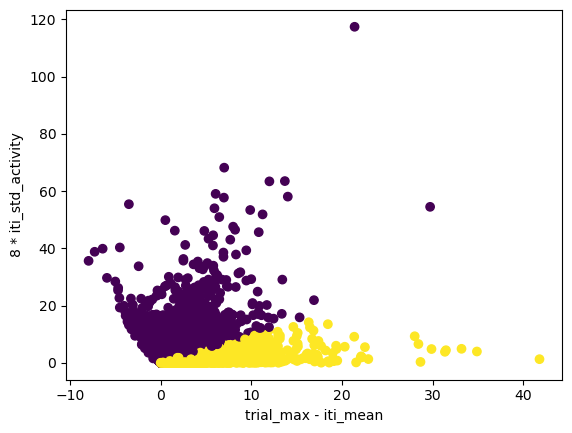

In [267]:
cells = [col for col in trial_auc_activity.index.to_list() if 'cell' in col]
a = trial_max_activity - iti_mean_activity
b = this_std * iti_std_activity
aa = np.array(a.to_list()).T
bb = np.array(b.to_list()).T
vis_trial_resps = pd.DataFrame(aa >= bb, columns=cells)

plt.scatter(aa.flatten(), bb.flatten(), c=vis_trial_resps.values.flatten())
plt.xlabel('trial_max - iti_mean')
plt.ylabel(f'{std} * iti_std_activity')

In [268]:
plot_dff_spikes_trials(this_exp, os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram'), save=False,
                                   plot_spikes=False, plot_trials=True, plot_running=False, 
                                   fig_width=15, fontsize='paper', cells_to_plot=np.random.choice(gen_resp_cells, min(10, len(gen_resp_cells)), replace=False))

In [ ]:
plot_dff_spikes_trials(this_exp, os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram'), save=False,
                                   plot_spikes=False, plot_trials=True, plot_running=False, 
                                   fig_width=15, fontsize='paper', cells_to_plot=np.random.choice(vis_gen_cells, min(10, len(vis_gen_cells)), replace=False))

In [ ]:
plot_dff_spikes_trials(this_exp, os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram'), save=False,
                                   plot_spikes=False, plot_trials=True, plot_running=False, 
                                   fig_width=15, fontsize='paper', cells_to_plot=np.random.choice(vis_no_gen_cells, min(10, len(vis_no_gen_cells)), replace=False))

In [ ]:
plot_dff_spikes_trials(this_exp, os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram'), save=False,
                                   plot_spikes=False, plot_trials=True, plot_running=False, 
                                   fig_width=15, fontsize='paper', cells_to_plot=np.random.choice(dir_gen_cells, min(10, len(dir_gen_cells)), replace=False))

In [ ]:
plot_dff_spikes_trials(this_exp, os.path.join(fig_path, '2_head_fixed_cells_traces_ethogram'), save=False,
                                   plot_spikes=False, plot_trials=True, plot_running=False, 
                                   fig_width=15, fontsize='paper', cells_to_plot=np.random.choice(dir_no_gen_cells, min(10, len(dir_no_gen_cells)), replace=False))